# Threshold Non-linearities
*Developed by Ruben Caljé*

This notebook compares two different options in Pastas for modeling threshold non-linear groundwater systems. We start with a basic model that contains a `StressModel2` to model the influence of precipitation and evaporation on groundwater head.

**Warning:** No noise model has been used in the models presented in this notebook. This might lead to wrong estimates of the parameter uncertainties.

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as pt

pt.set_log_level("WARNING")
pt.show_versions()

Python version: 3.9.6 (default, Nov  3 2021, 12:35:15) 
[GCC 9.3.0]
Numpy version: 1.20.1
Scipy version: 1.7.1
Pandas version: 1.2.4
Pastas version: 0.18.0
Matplotlib version: 3.4.2


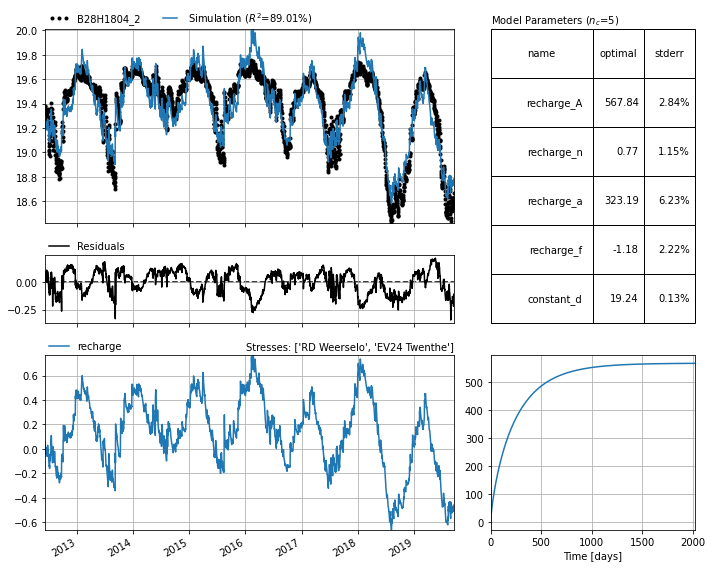

In [3]:
ml = pt.io.load("data_notebook_8/B28H1804_2.pas")
# the model is already solved, but we solve it again to be certain
ml.solve(noise=False, report=False)
# and we plot the results
ml.plots.results()

## ThresholdTransform
We can add a ThresholdTransform to model a threshold above which the groundwater reaction is damped. This transform is applied after the simulation is calculated. Therefore it can be added to any model. It adds two extra parameters: the level above and the factor by which the groundwater levels are damped. It is very effective for simulating the selected groundwater series. The $R^2$ value increases from 89% to 98%. We can see that the fit with the observations is much better, for both low and high measurement values.

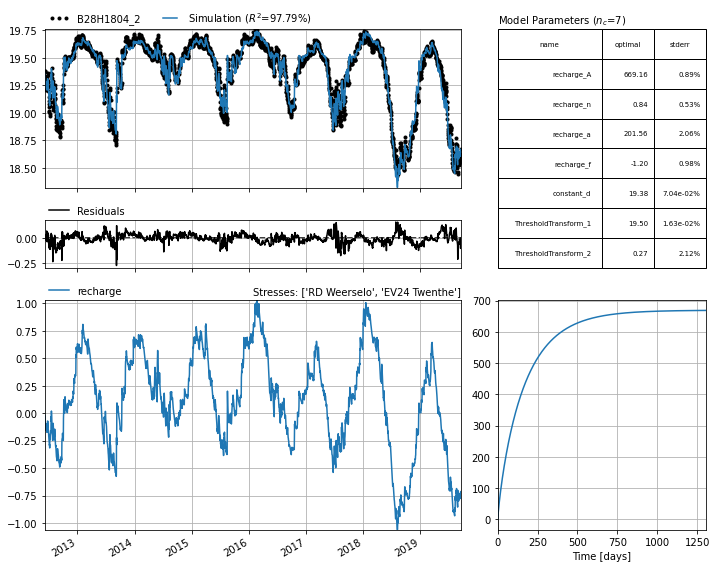

In [4]:
ml.add_transform(pt.ThresholdTransform())

ml.solve(noise=False, report=False)
ml.plots.results()

## TarsoModel
We can also model this series using a TarsoModel. Tarso stands for Threshold AutoRegressive Self-exciting Open-loop. The simulation is calculated by two exponential response functions, where the second response function becomes active when the simulation reaches a certain threshold-value.

Compared to the ThresholdTransform the simulation is not only damped above the threshold, but also the response time is changed above the threshold. A large drawback of the TarsoModel however is that it only allows the Exponential response function and it cannot be combined with other model elements (stressmodels, constant or transform). Therefore, all those other elements are removed from the model.

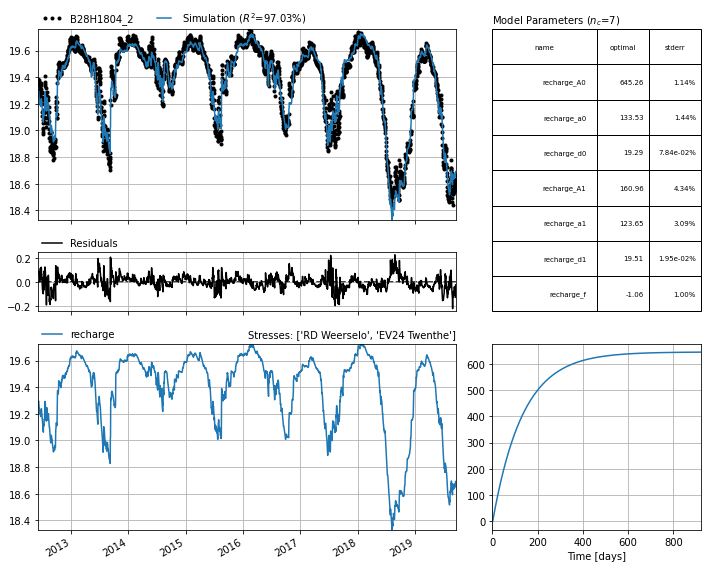

In [5]:
sm = ml.stressmodels["recharge"]
prec = sm.stress[0]
evap = sm.stress[1]

# delete all the stressmodels, the constant and the transform
ml.del_stressmodel("recharge")
ml.del_constant()
ml.del_transform()

# then add a TarsoModel
sm = pt.TarsoModel(prec, evap, ml.oseries)
ml.add_stressmodel(sm)

# and solve and plot the results again
ml.solve(noise=False, report=False)
ml.plots.results()

The fit of the Tarso model (two exponential response functions) is similar to the fit of the Gamma response function with a ThresholdTransform (a damping transformation above a threshold).
It is possible to interpret the TarsoModel as a physical model. In this model, there are two discharges with different resistances, where the second discharge is not always active. This model can be visulized by the image below (taken from https://edepot.wur.nl/406715).

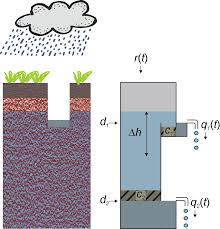

In this model d1 and c1 are equal to our parameters d1 and A1, d2 and c2 are equal to our parameters d0 and A0. We can then calculate the water balance and plot it with the code below. In this plot, all the in-fluxes (mainly precipitation) are positive, and all the out-fluxes (mainly evaporation) are negative. An exception is the storage term, to make sure the positive an negative balance terms level out. An increase in storage has a negative sign, and a decrease in storage has a positive sign.

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


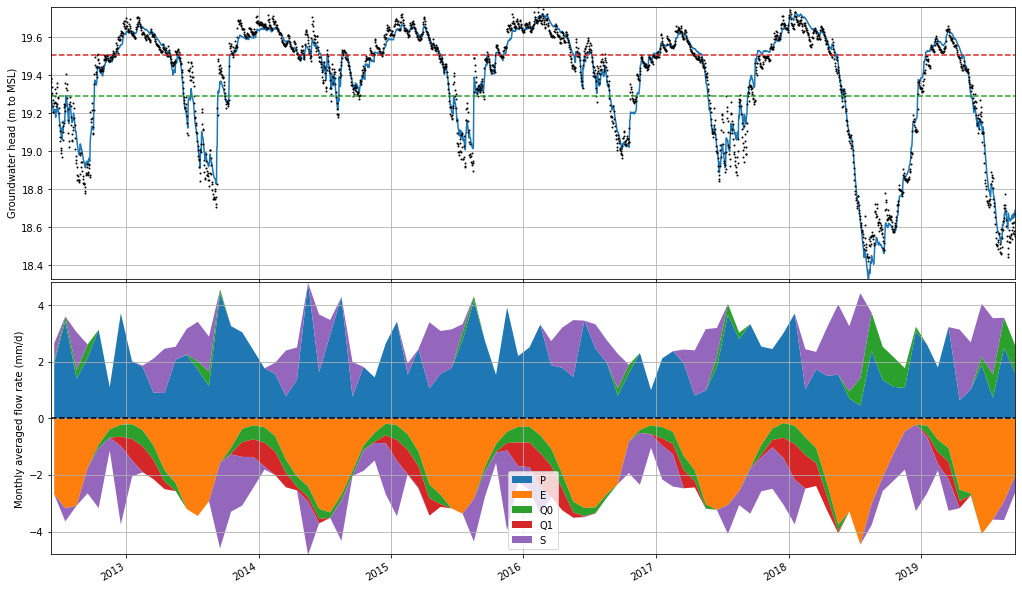

In [6]:
# calculate the water balance
sim = ml.simulate()
P = prec.series[sim.index[0] :]
E = -evap.series[sim.index[0] :]
p = ml.get_parameters("recharge")
Q0 = -(sim - p[2]) / p[0]
Q1 = -(sim - p[5]) / p[3]
Q1[sim < p[5]] = 0.0
# calculate storage
S = -(P + E + Q0 + Q1)
# combine these Series in a DataFrame
df = pd.DataFrame({"P": P, "E": E, "Q0": Q0, "Q1": Q1, "S": S}) * 1000
# resample the balance to monthly values, to make the graph more readable
df = df.resample("M").mean()
# and set the index to the middle of the month
df.index = df.index - (df.index - (df.index - pd.offsets.MonthBegin())) / 2

# make a new figure
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))

# plot heads in the upper graph
ax[0].set_ylabel("Groundwater head (m to MSL)")
sim.plot(ax=ax[0], x_compat=True)
ml.observations().plot(
    ax=ax[0], marker=".", color="k", x_compat=True, markersize=2, linestyle="none"
)
ax[0].axhline(p[2], linestyle="--", color="C2")
ax[0].axhline(p[5], linestyle="--", color="C3")

# plot discharges in the lower graph
ax[1].set_ylabel("Monthly averaged flow rate (mm/d)")
color = ["C0", "C1", "C2", "C3", "C4"]
df_up = df.where(df > 0, np.NaN)
df_down = df.where(df < 0, np.NaN)
df_up.plot.area(ax=ax[1], x_compat=True, color=color, linewidth=0)
df_down.plot.area(ax=ax[1], x_compat=True, color=color, linewidth=0, legend=False)
ax[1].axhline(0.0, linestyle="--", color="k")

# set some stuff for both axes
for iax in ax:
    iax.autoscale(tight=True)
    iax.minorticks_off()
    iax.grid(True)

# and remove white space
f.tight_layout(pad=0.0)